# Examples of retreiving information from Butler and Headers of all Images in an EO run

In [78]:
import numpy as np
import pandas as pd
import scipy as sp
import time
from tabulate import tabulate

import lsst.daf.butler as daf_butler
import lsst.afw.math as afw_math
from matplotlib import pyplot as plt
from astropy.stats import sigma_clip
from astropy.io import fits
from scipy.stats import skew
import logging

import lsst.afw.display as afwDisplay
from astropy.visualization import imshow_norm, MinMaxInterval,AsinhStretch,LinearStretch,SqrtStretch,ZScaleInterval,AsymmetricPercentileInterval,ManualInterval

from myutils import *

In [79]:
repo = '/repo/ir2'
collections = ['LSSTCam/raw/all']
butler_raw = daf_butler.Butler(repo, collections=collections)

In [90]:
runnum = '13391'
dsrefs = get_dsrefs(runnum,butler_raw)
df = get_run_info(runnum,butler_raw,detector=1)

In [115]:
print(tabulate(df,headers = 'keys', tablefmt = 'psql',floatfmt='0.3f'))

+-----+-------------------+---------------+----------------------+-----------------+-------------+--------------------+----------------------+-----------+-----------+-------------+-----------+------------+-----------------+
|     | physical_filter   |            id | obs_id               |   exposure_time |   dark_time | observation_type   | observation_reason   |   day_obs |   seq_num |   mjd_begin |   mjd_end |   detector |   mjd_delta_sec |
|-----+-------------------+---------------+----------------------+-----------------+-------------+--------------------+----------------------+-----------+-----------+-------------+-----------+------------+-----------------|
|  42 | unknown           | 3023062100268 | MC_C_20230621_000268 |           0.000 |       0.080 | bias               | bias                 |  20230621 |       268 |   60117.004 | 60117.004 |          1 |           0.080 |
| 151 | unknown           | 3023062100269 | MC_C_20230621_000269 |           0.000 |       0.081 | bias 

In [92]:
df['mjd_delta_sec'] =  24.*3600.*(df.mjd_end-df.mjd_begin)

In [96]:
# now from the header...
detector =112  #R24_S11
dsrefs = get_dsrefs(runnum,butler_raw,detector=detector)

In [97]:
# get metadata from a set of images
def get_metadata(butler,dsrefs,keys):
    sttime = time.time()

    dfdictm = {}
    for akey in keys:
        dfdictm[akey] = []

    print("Number of images: ",len(dsrefs))
    for i,aref in enumerate(dsrefs):
        rawmeta = butler.get(aref.makeComponentRef("metadata"))
        for akey in keys:
            dfdictm[akey].append(rawmeta[akey])
        
    edtime = time.time()

    print('Total time: ',edtime-sttime)

    dfmeta = pd.DataFrame(dfdictm)
    dfmetas = dfmeta.sort_values(by=['MJD-BEG'],ignore_index=True)
    return dfmetas


In [98]:
keys = ['OBSID','DAYOBS','SEQNUM','MJD-OBS','MJD-TRG','MJD-BEG','MJD-END','EXPTIME','DARKTIME','IMGTYPE','TESTTYPE','FILTER','FILTER1','FILTER2','CCOBLED','CCOBCURR','CCOBFLST','PROJTIME','CCOBFLUX','MJDPBEG','MJDPEND','TEMP6','TEMP10','CCDTEMP','BSSVBS']
dfmeta = get_metadata(butler_raw,dsrefs,keys)
dfmeta['MJD-DIFF'] = 24.*3600.*(dfmeta['MJD-END']-dfmeta['MJD-BEG'])


Number of images:  218
Total time:  23.249271154403687


In [100]:
print(tabulate(dfmeta[['OBSID','MJD-DIFF','EXPTIME','DARKTIME','IMGTYPE','TESTTYPE','FILTER','FILTER1','CCOBLED','CCOBCURR','CCOBFLUX','TEMP6','CCDTEMP','BSSVBS']],headers = 'keys', tablefmt = 'psql',floatfmt='0.3f'))

+-----+----------------------+------------+-----------+------------+-----------+-----------------+----------+-----------+-----------+------------+------------+---------+-----------+----------+
|     | OBSID                |   MJD-DIFF |   EXPTIME |   DARKTIME | IMGTYPE   | TESTTYPE        | FILTER   | FILTER1   | CCOBLED   |   CCOBCURR |   CCOBFLUX |   TEMP6 |   CCDTEMP |   BSSVBS |
|-----+----------------------+------------+-----------+------------+-----------+-----------------+----------+-----------+-----------+------------+------------+---------+-----------+----------|
|   0 | MC_C_20230621_000268 |      0.080 |     0.000 |      0.080 | BIAS      | BIAS            |          |           |           |    nan     |    nan     |  -6.188 |   -98.287 |   49.975 |
|   1 | MC_C_20230621_000269 |      0.081 |     0.000 |      0.081 | BIAS      | BIAS            |          |           |           |    nan     |    nan     |  -6.188 |   -98.287 |   49.975 |
|   2 | MC_C_20230621_000270 |     

Text(0.5, 1.0, 'Run 13391 Flat Images')

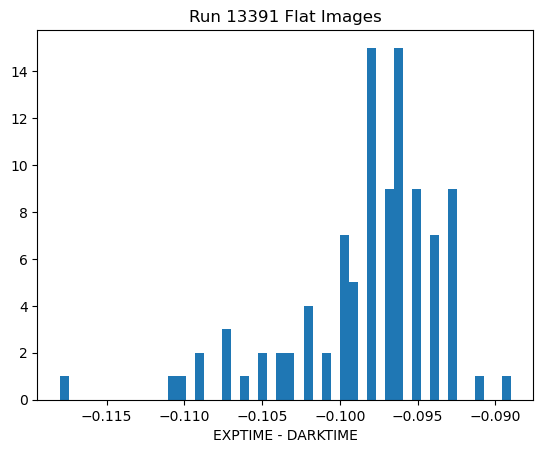

In [104]:
# DarkTime - ExpTime
f,ax = plt.subplots(1,1)
flats = (dfmeta['IMGTYPE'] == 'FLAT')
h = ax.hist(dfmeta[flats]['EXPTIME']-dfmeta[flats]['DARKTIME'],bins=50)
ax.set_xlabel('EXPTIME - DARKTIME')
ax.set_title('Run %s Flat Images'%(runnum))

In [105]:
apath = butler_raw.datastore.getURI(dsrefs[30])
print(apath.path)


/LSSTCam/20230621/MC_C_20230621_000437/MC_C_20230621_000437_R24_S11.fits


## individual Meta Data and Headers

In [106]:
raw = butler_raw.get(dsrefs[30])

In [107]:
print(raw.getMetadata())

SIMPLE = 1
// Java FITS: Wed Jun 21 17:00:05 PDT 2023
EXTEND = 1
// Extensions are permitted
DATE = "2023-06-22T01:27:29.569"
// Creation Date and Time of File
MJD = 60117.060758900
// Modified Julian Date that the file was written
RUNNUM = "13391"
// The Run Number
CCD_MANU = "E2V"
// CCD Manufacturer
CCD_TYPE = "CCD250"
// CCD Model Number
TESTTYPE = "FLAT"
// BIAS, DARK, FE55, FLAT, LAMBDA, PERSISTENCE, SPOT, SFLAT_<lam
IMGTYPE = "FLAT"
// BIAS, DARK, FE55, FLAT, FLAT_<lam>, SPOT, PPUMP
DETSIZE = "[1:4096,1:4004]"
EXPTIME = 15.000000000000
// Exposure Time in Seconds
FILENAME = "MC_C_20230621_000437_R24_S11.fits"
// Original name of the file
BINX = 1
// [pixels] binning along X axis
BINY = 1
// [pixels] binning along Y axis
CCDGAIN = 1.0000000000000
// Rough guess at overall system gain (e-/DNB)
CCDNOISE = 10.000000000000
// Rough guess at system noise (e- rms)
DATE-OBS = "2023-06-22T01:27:14.463"
// Time at the start of integration
MJD-OBS = 60117.060584063
// Modified Julian Date 

In [108]:
rawmeta = butler_raw.get(dsrefs[30].makeComponentRef("metadata"))

In [109]:
print(rawmeta['EXPTIME'])

15.0


In [110]:
print(rawmeta.names())

['DATASUM', 'BSSIBS', 'HTRVA', 'HTRVB', 'CKLVS', 'CKLVA', 'CKLVB', 'CKHVS', 'CKHIA', 'CKLIA', 'CKHVA', 'CKHIB', 'CKHVB', 'ODVS', 'ODVA2', 'ODVA', 'ODIB', 'ANAIS', 'ANAVB', 'DIGIA', 'DIGVA', 'DIGIB', 'HVBIAS', 'AP1_TM', 'AP0_TM', 'AP0_AF1', 'AP0_CLMP', 'AP0_GAIN', 'AP0_RC', 'RG_LOWP', 'ANAIA', 'IMGTYPE', 'FILTER2', 'DAQVERS', 'CCD_MANU', 'SIMPLE', 'MJD', 'EXTEND', 'IHVERS', 'FILENAME', 'CLKLPS_I', 'POWER', 'TEMPLED1', 'CCOBFLUX', 'CLKLPS_V', 'TSTAND', 'SEQNUM', 'HTRVAS', 'HTRIA', 'PLATFORM', 'FIRMWARE', 'SEQCKSUM', 'HTRIB', 'HTRPS_V', 'TEMPLED2', 'DIGVB', 'CCOBADC', 'HIERARCH ASTRO METADATA FIX DATE', 'RAFTBAY', 'DIGVS', 'RG_HIP', 'LSST_NUM', 'DAQPART', 'HIERARCH ASTRO METADATA FIX MODIFIED', 'DETSIZE', 'CCD_TYPE', 'RAFTNAME', 'DARKTIME', 'RGU_V', 'MJD-END', 'AP1_GAIN', 'TEMP5', 'MJDPEND', 'TESTTYPE', 'CCOBLED', 'DATEPEND', 'MJD-TRG', 'PROJTIME', 'FILTER1', 'TEMP3', 'INSTRUME', 'AP1_AF1', 'TIMESYS', 'CCDNOISE', 'RUNNUM', 'SCKL_V', 'AP1_RC', 'GDV', 'BINX', 'ANAPS_V', 'SCK_LOWP', 'DATE-BE

In [111]:
print(rawmeta)

SIMPLE = 1
// Java FITS: Wed Jun 21 17:00:05 PDT 2023
EXTEND = 1
// Extensions are permitted
DATE = "2023-06-22T01:27:29.569"
// Creation Date and Time of File
MJD = 60117.060758900
// Modified Julian Date that the file was written
RUNNUM = "13391"
// The Run Number
CCD_MANU = "E2V"
// CCD Manufacturer
CCD_TYPE = "CCD250"
// CCD Model Number
TESTTYPE = "FLAT"
// BIAS, DARK, FE55, FLAT, LAMBDA, PERSISTENCE, SPOT, SFLAT_<lam
IMGTYPE = "FLAT"
// BIAS, DARK, FE55, FLAT, FLAT_<lam>, SPOT, PPUMP
DETSIZE = "[1:4096,1:4004]"
EXPTIME = 15.000000000000
// Exposure Time in Seconds
FILENAME = "MC_C_20230621_000437_R24_S11.fits"
// Original name of the file
BINX = 1
// [pixels] binning along X axis
BINY = 1
// [pixels] binning along Y axis
CCDGAIN = 1.0000000000000
// Rough guess at overall system gain (e-/DNB)
CCDNOISE = 10.000000000000
// Rough guess at system noise (e- rms)
DATE-OBS = "2023-06-22T01:27:14.463"
// Time at the start of integration
MJD-OBS = 60117.060584063
// Modified Julian Date 

In [112]:
print(rawmeta.paramNames())

['DATASUM', 'BSSIBS', 'HTRVA', 'HTRVB', 'CKLVS', 'CKLVA', 'CKLVB', 'CKHVS', 'CKHIA', 'CKLIA', 'CKHVA', 'CKHIB', 'CKHVB', 'ODVS', 'ODVA2', 'ODVA', 'ODIB', 'ANAIS', 'ANAVB', 'DIGIA', 'DIGVA', 'DIGIB', 'HVBIAS', 'AP1_TM', 'AP0_TM', 'AP0_AF1', 'AP0_CLMP', 'AP0_GAIN', 'AP0_RC', 'RG_LOWP', 'ANAIA', 'IMGTYPE', 'FILTER2', 'DAQVERS', 'CCD_MANU', 'SIMPLE', 'MJD', 'EXTEND', 'IHVERS', 'FILENAME', 'CLKLPS_I', 'POWER', 'TEMPLED1', 'CCOBFLUX', 'CLKLPS_V', 'TSTAND', 'SEQNUM', 'HTRVAS', 'HTRIA', 'PLATFORM', 'FIRMWARE', 'SEQCKSUM', 'HTRIB', 'HTRPS_V', 'TEMPLED2', 'DIGVB', 'CCOBADC', 'HIERARCH ASTRO METADATA FIX DATE', 'RAFTBAY', 'DIGVS', 'RG_HIP', 'LSST_NUM', 'DAQPART', 'HIERARCH ASTRO METADATA FIX MODIFIED', 'DETSIZE', 'CCD_TYPE', 'RAFTNAME', 'DARKTIME', 'RGU_V', 'MJD-END', 'AP1_GAIN', 'TEMP5', 'MJDPEND', 'TESTTYPE', 'CCOBLED', 'DATEPEND', 'MJD-TRG', 'PROJTIME', 'FILTER1', 'TEMP3', 'INSTRUME', 'AP1_AF1', 'TIMESYS', 'CCDNOISE', 'RUNNUM', 'SCKL_V', 'AP1_RC', 'GDV', 'BINX', 'ANAPS_V', 'SCK_LOWP', 'DATE-BE